In [3]:
# !pip install -r requierments.txt

In [5]:

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, get_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostRegressor
import time

Matplotlib is building the font cache; this may take a moment.
c:\prog\practi5\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



# Загрузка данных


In [6]:

data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
X = data.data.copy()
y = data.target.copy()

print(df.shape)
df.head()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



# Выборка

In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16512, 8), (4128, 8), (16512,), (4128,))


# Модели и метрики


In [8]:
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [9]:
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
pred_lr = pipeline_lr.predict(X_test)
metrics_lr = metrics(y_test, pred_lr)

rf = RandomForestRegressor(
    n_estimators=200, random_state=42, n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
metrics_rf = metrics(y_test, pred_rf)

print("LinearRegression:", metrics_lr)
print("RandomForestRegressor:", metrics_rf)

LinearRegression: {'MAE': 0.5332001304956565, 'RMSE': 0.7455813830127764, 'R2': 0.5757877060324508}
RandomForestRegressor: {'MAE': 0.3267816481225778, 'RMSE': 0.5039404312719632, 'R2': 0.8062009933635497}



# Графики остатков

In [ ]:
def pred_vs_actual_plot(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def residuals_vs_pred_plot(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_pred, y_true - y_pred, alpha=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.show()

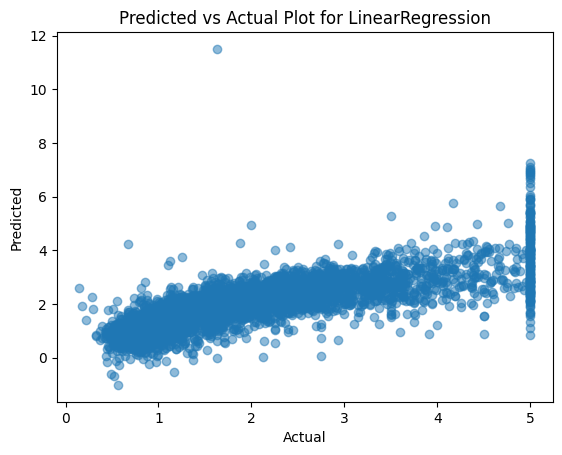

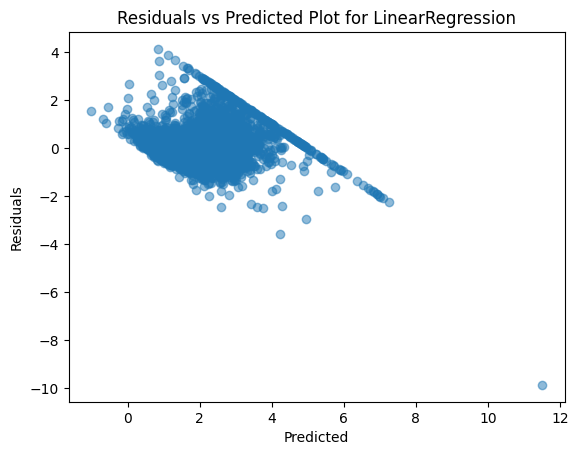

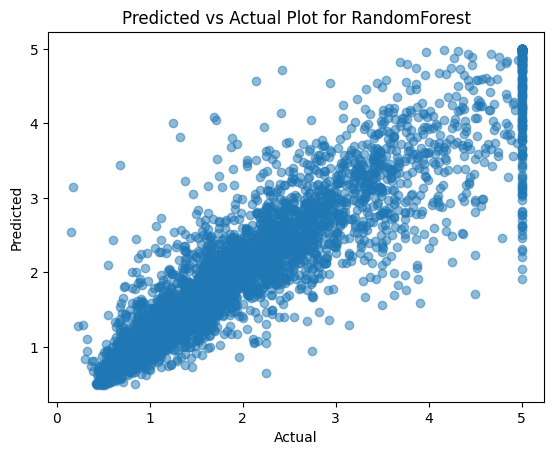

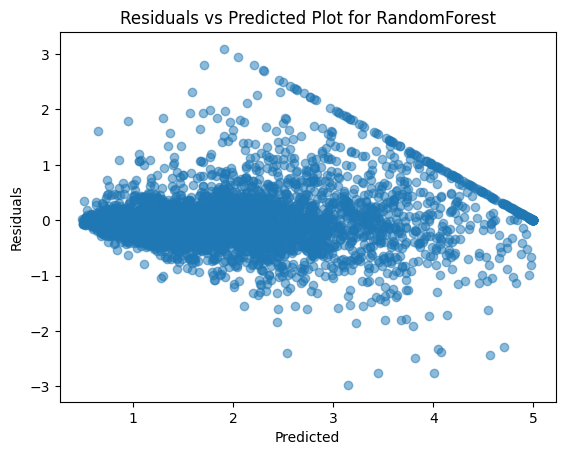

In [11]:
pred_vs_actual_plot(y_test.values, pred_lr,
                    title="Predicted vs Actual Plot for LinearRegression")
residuals_vs_pred_plot(y_test.values, pred_lr,
                       title="Residuals vs Predicted Plot for LinearRegression")

pred_vs_actual_plot(y_test.values, pred_rf,
                    title="Predicted vs Actual Plot for RandomForest")
residuals_vs_pred_plot(y_test.values, pred_rf,
                       title="Residuals vs Predicted Plot for RandomForest")

# Подбор гиперпараметров

In [12]:
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

In [13]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 600, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    base_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_scores = []

    indexes = np.arange(len(X_train))

    for fold_id, (train, valid) in enumerate(crossvalidation.split(indexes)):
        model = clone(base_model)

        X_tr = X_train.iloc[train]
        y_tr = y_train.iloc[train]
        X_vl = X_train.iloc[valid]
        y_vl = y_train.iloc[valid]

        try:
            model.fit(X_tr, y_tr)
            y_pr = model.predict(X_vl)
            score_rmse = rmse(y_vl, y_pr)
        except Exception as e:
            print(f"trial={trial.number} | fold {fold_id} error: {e}")
            score_rmse = float("inf")

        fold_scores.append(score_rmse)

        print(f"trial={trial.number} | fold {fold_id}: RMSE={score_rmse}")

    mean_rmse = float(np.mean(fold_scores)) if len(
        fold_scores) else float("inf")
    print(f"trial={trial.number} | mean RMSE={mean_rmse}")
    return -mean_rmse

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_rf, n_trials=30)

print("Best params:", study.best_params)
print("Best (neg-RMSE):", study.best_value)

[I 2025-10-09 12:37:43,981] A new study created in memory with name: no-name-25de9e51-fe68-4094-b086-2cb4f348da4e


trial=0 | fold 0: RMSE=0.5237022363979078
trial=0 | fold 1: RMSE=0.5244943135972169


[I 2025-10-09 12:37:58,412] Trial 0 finished with value: -0.5279140530678105 and parameters: {'n_estimators': 600, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: -0.5279140530678105.


trial=0 | fold 2: RMSE=0.5355456092083068
trial=0 | mean RMSE=0.5279140530678105
trial=1 | fold 0: RMSE=0.5159928729187914
trial=1 | fold 1: RMSE=0.5179366585137687


[I 2025-10-09 12:38:05,512] Trial 1 finished with value: -0.5209481255009875 and parameters: {'n_estimators': 250, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 1 with value: -0.5209481255009875.


trial=1 | fold 2: RMSE=0.5289148450704024
trial=1 | mean RMSE=0.5209481255009875
trial=2 | fold 0: RMSE=0.5116860072031555
trial=2 | fold 1: RMSE=0.5132227888891422


[I 2025-10-09 12:38:12,221] Trial 2 finished with value: -0.5160985011866147 and parameters: {'n_estimators': 200, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 2 with value: -0.5160985011866147.


trial=2 | fold 2: RMSE=0.5233867074675462
trial=2 | mean RMSE=0.5160985011866147
trial=3 | fold 0: RMSE=0.5242102221240839
trial=3 | fold 1: RMSE=0.5247262018560207


[I 2025-10-09 12:38:17,707] Trial 3 finished with value: -0.5287044342098152 and parameters: {'n_estimators': 200, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 8}. Best is trial 2 with value: -0.5160985011866147.


trial=3 | fold 2: RMSE=0.5371768786493409
trial=3 | mean RMSE=0.5287044342098152
trial=4 | fold 0: RMSE=0.5157380302624031
trial=4 | fold 1: RMSE=0.5201053781747215


[I 2025-10-09 12:38:51,123] Trial 4 finished with value: -0.5213892863069541 and parameters: {'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 2 with value: -0.5160985011866147.


trial=4 | fold 2: RMSE=0.5283244504837378
trial=4 | mean RMSE=0.5213892863069541
trial=5 | fold 0: RMSE=0.5178134193110914
trial=5 | fold 1: RMSE=0.5192992003011387


[I 2025-10-09 12:39:30,238] Trial 5 finished with value: -0.5225037059884498 and parameters: {'n_estimators': 600, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: -0.5160985011866147.


trial=5 | fold 2: RMSE=0.5303984983531191
trial=5 | mean RMSE=0.5225037059884498
trial=6 | fold 0: RMSE=0.5212094920805619
trial=6 | fold 1: RMSE=0.5229517531195427


[I 2025-10-09 12:39:40,623] Trial 6 finished with value: -0.5262252543508876 and parameters: {'n_estimators': 150, 'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 2 with value: -0.5160985011866147.


trial=6 | fold 2: RMSE=0.5345145178525582
trial=6 | mean RMSE=0.5262252543508876
trial=7 | fold 0: RMSE=0.5415205907094047
trial=7 | fold 1: RMSE=0.5450860794560279


[I 2025-10-09 12:39:49,905] Trial 7 finished with value: -0.5459343510807081 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 1}. Best is trial 2 with value: -0.5160985011866147.


trial=7 | fold 2: RMSE=0.5511963830766917
trial=7 | mean RMSE=0.5459343510807081
trial=8 | fold 0: RMSE=0.5192094330127275
trial=8 | fold 1: RMSE=0.5207568546327764


[I 2025-10-09 12:40:15,336] Trial 8 finished with value: -0.5241608166370035 and parameters: {'n_estimators': 400, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 5}. Best is trial 2 with value: -0.5160985011866147.


trial=8 | fold 2: RMSE=0.5325161622655067
trial=8 | mean RMSE=0.5241608166370035
trial=9 | fold 0: RMSE=0.7764687586838859
trial=9 | fold 1: RMSE=0.7568323649426394


[I 2025-10-09 12:40:17,196] Trial 9 finished with value: -0.7660309967728495 and parameters: {'n_estimators': 200, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 2 with value: -0.5160985011866147.


trial=9 | fold 2: RMSE=0.7647918666920233
trial=9 | mean RMSE=0.7660309967728495
trial=10 | fold 0: RMSE=0.5287584760033333
trial=10 | fold 1: RMSE=0.5297478440571599


[I 2025-10-09 12:40:25,401] Trial 10 finished with value: -0.5332542293919084 and parameters: {'n_estimators': 350, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 2 with value: -0.5160985011866147.


trial=10 | fold 2: RMSE=0.5412563681152319
trial=10 | mean RMSE=0.5332542293919084
trial=11 | fold 0: RMSE=0.5207450153843839
trial=11 | fold 1: RMSE=0.5225344512593392


[I 2025-10-09 12:40:31,842] Trial 11 finished with value: -0.5257207265376221 and parameters: {'n_estimators': 250, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 2 with value: -0.5160985011866147.


trial=11 | fold 2: RMSE=0.5338827129691435
trial=11 | mean RMSE=0.5257207265376221
trial=12 | fold 0: RMSE=0.5156970893151273
trial=12 | fold 1: RMSE=0.5183488266517687


[I 2025-10-09 12:40:40,093] Trial 12 finished with value: -0.5211259495320603 and parameters: {'n_estimators': 300, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 2 with value: -0.5160985011866147.


trial=12 | fold 2: RMSE=0.5293319326292847
trial=12 | mean RMSE=0.5211259495320603
trial=13 | fold 0: RMSE=0.5132854159563276
trial=13 | fold 1: RMSE=0.518131718990073


[I 2025-10-09 12:40:43,441] Trial 13 finished with value: -0.5191930563542863 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 2 with value: -0.5160985011866147.


trial=13 | fold 2: RMSE=0.5261620341164585
trial=13 | mean RMSE=0.5191930563542863
trial=14 | fold 0: RMSE=0.5135605453386657
trial=14 | fold 1: RMSE=0.5182577064048592


[I 2025-10-09 12:40:46,965] Trial 14 finished with value: -0.5190210961393541 and parameters: {'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 2 with value: -0.5160985011866147.


trial=14 | fold 2: RMSE=0.525245036674537
trial=14 | mean RMSE=0.5190210961393541
trial=15 | fold 0: RMSE=0.5192655449421889
trial=15 | fold 1: RMSE=0.5247313724402529


[I 2025-10-09 12:40:50,136] Trial 15 finished with value: -0.5251119081668714 and parameters: {'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 2 with value: -0.5160985011866147.


trial=15 | fold 2: RMSE=0.531338807118172
trial=15 | mean RMSE=0.5251119081668714
trial=16 | fold 0: RMSE=0.5142077230248339
trial=16 | fold 1: RMSE=0.5192457494000926


[I 2025-10-09 12:40:53,546] Trial 16 finished with value: -0.5198019112670614 and parameters: {'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 2 with value: -0.5160985011866147.


trial=16 | fold 2: RMSE=0.525952261376258
trial=16 | mean RMSE=0.5198019112670614
trial=17 | fold 0: RMSE=0.5086527135193084
trial=17 | fold 1: RMSE=0.5115206987798768


[I 2025-10-09 12:41:12,883] Trial 17 finished with value: -0.5139715363204834 and parameters: {'n_estimators': 400, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 17 with value: -0.5139715363204834.


trial=17 | fold 2: RMSE=0.5217411966622653
trial=17 | mean RMSE=0.5139715363204834
trial=18 | fold 0: RMSE=0.5082957184587168
trial=18 | fold 1: RMSE=0.5118987928070835


[I 2025-10-09 12:41:29,228] Trial 18 finished with value: -0.5136752488280719 and parameters: {'n_estimators': 450, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 18 with value: -0.5136752488280719.


trial=18 | fold 2: RMSE=0.5208312352184153
trial=18 | mean RMSE=0.5136752488280719
trial=19 | fold 0: RMSE=0.50821140397666
trial=19 | fold 1: RMSE=0.5117594538289626


[I 2025-10-09 12:41:55,090] Trial 19 finished with value: -0.5136720610034106 and parameters: {'n_estimators': 450, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 19 with value: -0.5136720610034106.


trial=19 | fold 2: RMSE=0.521045325204609
trial=19 | mean RMSE=0.5136720610034106
trial=20 | fold 0: RMSE=0.5119779219992743
trial=20 | fold 1: RMSE=0.5145067918070118


[I 2025-10-09 12:42:19,985] Trial 20 finished with value: -0.5171791794131796 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 19 with value: -0.5136720610034106.


trial=20 | fold 2: RMSE=0.5250528244332529
trial=20 | mean RMSE=0.5171791794131796
trial=21 | fold 0: RMSE=0.50821140397666
trial=21 | fold 1: RMSE=0.5117594538289626


[I 2025-10-09 12:42:35,533] Trial 21 finished with value: -0.5136720610034106 and parameters: {'n_estimators': 450, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 19 with value: -0.5136720610034106.


trial=21 | fold 2: RMSE=0.5210453252046091
trial=21 | mean RMSE=0.5136720610034106
trial=22 | fold 0: RMSE=0.5078309178850451
trial=22 | fold 1: RMSE=0.5116879890181737


[I 2025-10-09 12:42:52,693] Trial 22 finished with value: -0.5133130626738059 and parameters: {'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 22 with value: -0.5133130626738059.


trial=22 | fold 2: RMSE=0.5204202811181988
trial=22 | mean RMSE=0.5133130626738059
trial=23 | fold 0: RMSE=0.5077202209040855
trial=23 | fold 1: RMSE=0.5114241894047721


[I 2025-10-09 12:43:11,251] Trial 23 finished with value: -0.513111954853638 and parameters: {'n_estimators': 500, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 23 with value: -0.513111954853638.


trial=23 | fold 2: RMSE=0.5201914542520565
trial=23 | mean RMSE=0.513111954853638
trial=24 | fold 0: RMSE=0.5096048647654524
trial=24 | fold 1: RMSE=0.5127017322942087


[I 2025-10-09 12:43:44,126] Trial 24 finished with value: -0.5149175759183032 and parameters: {'n_estimators': 550, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 23 with value: -0.513111954853638.


trial=24 | fold 2: RMSE=0.5224461306952484
trial=24 | mean RMSE=0.5149175759183032
trial=25 | fold 0: RMSE=0.5126330485026662
trial=25 | fold 1: RMSE=0.51508739279893


[I 2025-10-09 12:44:01,626] Trial 25 finished with value: -0.5177749662615109 and parameters: {'n_estimators': 500, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 23 with value: -0.513111954853638.


trial=25 | fold 2: RMSE=0.5256044574829364
trial=25 | mean RMSE=0.5177749662615109
trial=26 | fold 0: RMSE=0.5084309590549062
trial=26 | fold 1: RMSE=0.5115450920895805


[I 2025-10-09 12:44:25,168] Trial 26 finished with value: -0.5137614654543681 and parameters: {'n_estimators': 550, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 23 with value: -0.513111954853638.


trial=26 | fold 2: RMSE=0.5213083452186177
trial=26 | mean RMSE=0.5137614654543681
trial=27 | fold 0: RMSE=0.5288330220230109
trial=27 | fold 1: RMSE=0.5298831364917904


[I 2025-10-09 12:44:35,085] Trial 27 finished with value: -0.533194458947153 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 23 with value: -0.513111954853638.


trial=27 | fold 2: RMSE=0.5408672183266576
trial=27 | mean RMSE=0.533194458947153
trial=28 | fold 0: RMSE=0.5995938208645273
trial=28 | fold 1: RMSE=0.6020492472087577


[I 2025-10-09 12:44:51,860] Trial 28 finished with value: -0.6015247588006333 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: -0.513111954853638.


trial=28 | fold 2: RMSE=0.6029312083286147
trial=28 | mean RMSE=0.6015247588006333
trial=29 | fold 0: RMSE=0.5090485599426317
trial=29 | fold 1: RMSE=0.5117582515992088


[I 2025-10-09 12:45:11,072] Trial 29 finished with value: -0.5142211374680817 and parameters: {'n_estimators': 600, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 23 with value: -0.513111954853638.


trial=29 | fold 2: RMSE=0.5218566008624048
trial=29 | mean RMSE=0.5142211374680817
Best params: {'n_estimators': 500, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best (neg-RMSE): -0.513111954853638


# Фабрика

In [15]:
def gen_objective(estimator_class, grid, X_train, y_train,
                  *, cv=3, scorer="neg_root_mean_squared_error",
                  fit_params=None, random_state=42, n_jobs=-1, verbose=True):
    fit_params = {} if fit_params is None else dict(fit_params)

    if not isinstance(grid, dict) or not grid:
        raise ValueError(
            "grid must be not empty dict ({param: (type, ...)})")

    def suggest_param(trial, name, spec):
        if not isinstance(spec, (tuple, list)) or not spec:
            raise ValueError(f"Error spec {name}: {spec}")
        ptype = spec[0]
        if ptype == "int":
            low, high = spec[1], spec[2]
            step = spec[3] if len(spec) > 3 else 1
            return trial.suggest_int(name, int(low), int(high), step=int(step))
        elif ptype == "float":
            low, high = float(spec[1]), float(spec[2])
            log = bool(spec[3]) if len(spec) > 3 else False
            return trial.suggest_float(name, low, high, log=log)
        elif ptype == "categorical":
            choices = list(spec[1])
            return trial.suggest_categorical(name, choices)
        else:
            raise ValueError(
                f"Error space type {ptype} for {name}")

    if isinstance(scorer, str):
        try:
            scorer_obj = get_scorer(scorer)
        except Exception:
            if verbose:
                print(
                    f"Error scorer={scorer} | used=neg_root_mean_squared_error")
            scorer_obj = get_scorer("neg_root_mean_squared_error")
    else:
        scorer_obj = scorer

    idx = np.arange(len(X_train))

    def objective(trial):
        t0 = time()

        params = {name: suggest_param(trial, name, spec)
                  for name, spec in grid.items()}

        try:
            probe = estimator_class()
            base_params = getattr(probe, "get_params", lambda: {})()
        except Exception:
            base_params = {}

        model_kwargs = {}
        if "random_state" in base_params:
            model_kwargs["random_state"] = random_state
        if "n_jobs" in base_params:
            model_kwargs["n_jobs"] = n_jobs

        model = estimator_class(**model_kwargs, **params)

        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        fold_scores = []

        for fold_id, (tr_idx, vl_idx) in enumerate(kf.split(idx), start=1):
            m = clone(model)
            X_tr = X_train.iloc[tr_idx]
            y_tr = y_train.iloc[tr_idx]
            X_vl = X_train.iloc[vl_idx]
            y_vl = y_train.iloc[vl_idx]

            try:
                m.fit(X_tr, y_tr, **fit_params)
                s = scorer_obj(m, X_vl, y_vl)
                s = float(s)
                if not np.isfinite(s):
                    if verbose:
                        print(
                            f"trial={trial.number} | fold {fold_id}: score is not finite, set to -1e12")
                    s = -1e12
            except Exception as e:
                if verbose:
                    print(
                        f"trial={trial.number} | fold {fold_id} error: {e}")
                s = -1e12

            fold_scores.append(s)

            if verbose:
                print(f"trial {trial.number} | fold {fold_id} score={s}")

        mean_score = float(np.mean(fold_scores)) if fold_scores else -1e12
        if not np.isfinite(mean_score):
            mean_score = -1e12

        if verbose:
            dt = time() - t0
            print(
                f"trial={trial.number} | mean_score={mean_score} | time={dt} | params={params}")

        return mean_score

    return objective

In [ ]:
catboost_grid = {
    "depth": ("int", 4, 10),
    "learning_rate": ("loguniform", 1e-3, 0.3),
    "l2_leaf_reg": ("loguniform", 1e-2, 10.0),
    "iterations": ("int", 200, 1500, 100),
}

objective_cb = gen_objective(
    CatBoostRegressor,
    catboost_grid,
    X_train,
    y_train,
    cv=3,
    scorer="neg_root_mean_squared_error", 
    fit_params={"verbose": False},         
    random_state=42,
    n_jobs=-1,                             
    verbose=True
)

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=30)

print("Best CatBoost:", study_cb.best_params, "score:", study_cb.best_value)

best_cb = CatBoostRegressor(
    **study_cb.best_params,
    loss_function="RMSE",
    random_state=42,
    verbose=False
)
best_cb.fit(X_train, y_train)

pred_best_cb = best_cb.predict(X_test)
print(metrics(y_test, pred_best_cb))

pred_vs_actual_plot(y_test.values, pred_best_cb, title="Predicted vs Actual Plot for CatBoost")
residuals_vs_pred_plot(y_test.values, pred_best_cb, title="Residuals vs Predicted Plot for CatBoost")
